In [2]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
from astropy import units as u
from astropy.coordinates import SkyCoord

import utils
import model_spectra as NN
import fitting

import matplotlib.pyplot as plt
import ipywidgets as widgets
from ipywidgets import interact
np.set_printoptions(formatter={'float': lambda x: "{0:0.2f}".format(x)})

# Check label recovery 

In [4]:
# read in the standard wavelength grid onto which we interpolate spectra.
wavelength = utils.load_wavelength_array()

# read in all individual neural networks we'll need. 
NN_coeffs = utils.read_in_neural_network(name='norm_spectra_approx')

# Generate a spectrum from labels and NN
feh = -2.0
alphafe = 0.0
alpha = alphafe + feh
Teff = 4100
logg = 0.5
dv = 0.0
real_labels = np.array([alphafe, alpha, alpha, alpha, alpha, alpha, alpha,
                        feh, Teff, logg, dv])
real_spec = NN.get_spectrum_from_neural_net(labels=real_labels, NN_coeffs=NN_coeffs)
data_spec = real_spec + 0.01 * np.random.randn(len(real_spec))
spec_err = 0.01 * np.ones(len(wavelength))

# Apply Mask
kirby_2008_stellar = utils.get_spectral_mask_dict(name='kirby_2008_stellar')
mask = utils.generate_mask_from_dict(**kirby_2008_stellar)
spec_err[mask] = 1e16

# Fit spectrum
popt, pcov, model_spec \
    = fitting.fit_normalized_spectrum_single_star_model(norm_spec = data_spec,
                                                        spec_err = spec_err,
                                                        NN_coeffs = NN_coeffs,
                                                        p0 = None, num_p0 = 1)

def plot1(lambda_bounds):
    # zoom in on a small region of the spectrum so we can see what's going on.
    lambda_min = lambda_bounds[0]
    lambda_max = lambda_bounds[1]
    m = (wavelength < lambda_max) & (wavelength > lambda_min)
    
    fig, (ax1, ax2) = plt.subplots(2, sharex=True, figsize=(14, 4))
    
    ax1.plot(wavelength[m], data_spec[m], 'k', lw=0.5, label = r'$\mathrm{Data\ Spectra}$')
    ax1.plot(wavelength[m], model_spec[m], 'r--', lw=0.75, label = r'$\mathrm{Best-Fit\ Model}$')
    ax1.set_xlim(lambda_min, lambda_max)
    ax1.set_ylim(0.70,1.10)
    ax1.set_ylabel(r'$\mathrm{Normalized\ Flux}$')
    ax1.legend(loc = 'best', frameon = False, fontsize = 12)
    
    ax2.plot(wavelength[m], data_spec[m]-model_spec[m], 'k', lw=0.5)
    ax2.hlines(0, lambda_min, lambda_max, linestyles='-.')
    ax2.set_ylim(-0.15,0.15)
    ax2.set_xlabel(r'$\mathrm{Wavelength\ [\AA]}$')
    ax2.set_ylabel(r'$\mathrm{Residuals}$')
    
    fig.subplots_adjust(hspace=0)
    plt.setp([a.get_xticklabels() for a in fig.axes[:-1]], visible=False)
    plt.show()
interact(plot1, lambda_bounds=widgets.IntRangeSlider(min=6250,max=9500,step=50,value=[8400,8700]))

print('Best Fit Labels:')
print(popt)

print('True Labels:')
print(real_labels)

interactive(children=(IntRangeSlider(value=(8400, 8700), description='lambda_bounds', max=9500, min=6250, step=50), Output()), _dom_classes=('widget-interact',))

Best Fit Labels:
[0.01 -1.98 -1.97 -2.02 -1.98 -1.99 -2.03 -2.01 4097.84 0.49 -0.11]
True Labels:
[0.00 -2.00 -2.00 -2.00 -2.00 -2.00 -2.00 -2.00 4100.00 0.50 0.00]


# Fitting Spectra from the Training Set

In [7]:
D_PayneDir = utils.D_PayneDir
SpectraDir = D_PayneDir + 'spectra/synth_spectra/'
SpectraFile = 'convolved_synthetic_spectra_MIST.npz'
temp = np.load(SpectraDir + SpectraFile)
spectra = temp['spectra']
norm_spectra = temp['norm_spectra_approx']
labels = temp['labels']
temp.close()

In [11]:
# Samples 10 spectra randomly from the training set
n = np.random.randint(0,len(norm_spectra),10)

for i, spec in enumerate(norm_spectra[n]):
    j = n[i]
    real_labels = np.append(labels[j],0.0)
    real_spec = spec
    data_spec = real_spec + 0.01 * np.random.randn(len(real_spec))
    spec_err = 0.01 * np.ones(len(real_spec))
    
    # Apply Mask
    kirby_2008_stellar = utils.get_spectral_mask_dict(name='kirby_2008_stellar')
    mask = utils.generate_mask_from_dict(**kirby_2008_stellar)
    spec_err[mask] = 1e16
    
    # Restore NN
    NN_coeffs = utils.read_in_neural_network(name='norm_spectra_approx')

    # Fit spectrum
    popt, pcov, model_spec \
    = fitting.fit_normalized_spectrum_single_star_model(norm_spec = data_spec,
                                                        spec_err = spec_err,
                                                        NN_coeffs = NN_coeffs,
                                                        p0 = None, num_p0 = 1)
    
    def plot2(lambda_bounds):
        # zoom in on a small region of the spectrum so we can see what's going on.
        lambda_min = lambda_bounds[0]
        lambda_max = lambda_bounds[1]
        m = (wavelength < lambda_max) & (wavelength > lambda_min)
        
        fig, (ax1, ax2) = plt.subplots(2, sharex=True, figsize=(14, 4))
        
        ax1.plot(wavelength[m], data_spec[m], 'k', lw=0.5, label = r'$\mathrm{Data\ Spectra}$')
        ax1.plot(wavelength[m], model_spec[m], 'r--', lw=0.75, label = r'$\mathrm{Best-Fit\ Model}$')
        ax1.set_xlim(lambda_min, lambda_max)
        ax1.set_ylim(0.70,1.10)
        ax1.set_ylabel(r'$\mathrm{Normalized\ Flux}$')
        ax1.legend(loc = 'best', frameon = False, fontsize = 12)
        
        ax2.plot(wavelength[m], data_spec[m]-model_spec[m], 'k', lw=0.5)
        ax2.hlines(0, lambda_min, lambda_max, linestyles='-.')
        ax2.set_ylim(-0.15,0.15)
        ax2.set_xlabel(r'$\mathrm{Wavelength\ [\AA]}$')
        ax2.set_ylabel(r'$\mathrm{Residuals}$')
        
        fig.subplots_adjust(hspace=0)
        plt.setp([a.get_xticklabels() for a in fig.axes[:-1]], visible=False)
        plt.show()
    interact(plot2, lambda_bounds=widgets.IntRangeSlider(min=6250,max=9500,step=50,value=[8400,8700]))
       
    print('Best Fit Labels:')
    print(popt)
    
    print('True Labels:')
    print(real_labels)

interactive(children=(IntRangeSlider(value=(8400, 8700), description='lambda_bounds', max=9500, min=6250, step=50), Output()), _dom_classes=('widget-interact',))

Best Fit Labels:
[-0.03 -1.90 -1.87 -1.88 -1.86 -1.89 -1.84 -1.84 4589.35 1.27 0.27]
True Labels:
[-0.20 -1.70 -1.70 -1.70 -1.70 -1.70 -1.70 -1.50 4824.96 1.95 0.00]


interactive(children=(IntRangeSlider(value=(8400, 8700), description='lambda_bounds', max=9500, min=6250, step=50), Output()), _dom_classes=('widget-interact',))

Best Fit Labels:
[-0.21 -1.24 -1.21 -1.19 -1.18 -1.22 -1.15 -0.97 4929.99 4.84 0.20]
True Labels:
[-0.20 -1.20 -1.20 -1.20 -1.20 -1.20 -1.20 -1.00 4938.33 4.78 0.00]


interactive(children=(IntRangeSlider(value=(8400, 8700), description='lambda_bounds', max=9500, min=6250, step=50), Output()), _dom_classes=('widget-interact',))

Best Fit Labels:
[1.00 1.01 1.00 1.00 1.02 1.01 1.01 0.01 5882.40 4.38 -0.21]
True Labels:
[1.00 1.00 1.00 1.00 1.00 1.00 1.00 0.00 5907.98 4.40 0.00]


interactive(children=(IntRangeSlider(value=(8400, 8700), description='lambda_bounds', max=9500, min=6250, step=50), Output()), _dom_classes=('widget-interact',))

Best Fit Labels:
[0.42 -1.31 -1.33 -1.32 -1.31 -1.34 -1.34 -1.74 4870.58 3.83 -0.39]
True Labels:
[0.40 -1.35 -1.35 -1.35 -1.35 -1.35 -1.35 -1.75 4884.38 3.82 0.00]


interactive(children=(IntRangeSlider(value=(8400, 8700), description='lambda_bounds', max=9500, min=6250, step=50), Output()), _dom_classes=('widget-interact',))

Best Fit Labels:
[0.11 -2.44 -2.46 -2.45 -2.46 -2.44 -2.41 -2.53 5977.86 3.70 0.01]
True Labels:
[-0.20 -2.70 -2.70 -2.70 -2.70 -2.70 -2.70 -2.50 5947.54 3.63 0.00]


interactive(children=(IntRangeSlider(value=(8400, 8700), description='lambda_bounds', max=9500, min=6250, step=50), Output()), _dom_classes=('widget-interact',))

Best Fit Labels:
[1.01 1.50 1.50 1.50 1.50 1.50 1.50 0.50 5877.23 3.51 0.06]
True Labels:
[1.00 1.50 1.50 1.50 1.50 1.50 1.50 0.50 5897.39 3.52 0.00]


interactive(children=(IntRangeSlider(value=(8400, 8700), description='lambda_bounds', max=9500, min=6250, step=50), Output()), _dom_classes=('widget-interact',))

Best Fit Labels:
[0.20 0.21 0.20 0.19 0.19 0.19 0.24 0.01 4889.84 3.64 0.19]
True Labels:
[0.20 0.20 0.20 0.20 0.20 0.20 0.20 0.00 4903.06 3.65 0.00]


interactive(children=(IntRangeSlider(value=(8400, 8700), description='lambda_bounds', max=9500, min=6250, step=50), Output()), _dom_classes=('widget-interact',))

Best Fit Labels:
[0.80 -0.43 -0.41 -0.41 -0.46 -0.38 -0.40 -1.19 4623.68 1.27 0.03]
True Labels:
[0.80 -0.45 -0.45 -0.45 -0.45 -0.45 -0.45 -1.25 4601.13 1.03 0.00]


interactive(children=(IntRangeSlider(value=(8400, 8700), description='lambda_bounds', max=9500, min=6250, step=50), Output()), _dom_classes=('widget-interact',))

Best Fit Labels:
[0.70 -1.71 -1.77 -1.74 -1.76 -1.69 -1.75 -2.42 5794.46 3.84 0.46]
True Labels:
[0.80 -1.70 -1.70 -1.70 -1.70 -1.70 -1.70 -2.50 5740.90 3.64 0.00]


interactive(children=(IntRangeSlider(value=(8400, 8700), description='lambda_bounds', max=9500, min=6250, step=50), Output()), _dom_classes=('widget-interact',))

Best Fit Labels:
[0.38 -2.43 -2.43 -2.38 -2.39 -2.37 -2.30 -2.75 6994.90 4.40 0.49]
True Labels:
[1.00 -2.00 -2.00 -2.00 -2.00 -2.00 -2.00 -3.00 7061.34 4.45 0.00]


# Fitting Real Spectra

In [13]:
wavelength = utils.load_wavelength_array()

D_PayneDir = utils.D_PayneDir
SpectraDir = D_PayneDir + 'spectra/M15/'
SpectraFile = 'm15_Horne.npz'
temp = np.load(SpectraDir + SpectraFile)
obj = temp['obj']
spec = temp['spec']
spectral_err = temp['spec_err']
dv = temp['dv']
RA_Dec = SkyCoord(temp['RA_Dec'])
temp.close()

In [14]:
# Samples 5 spectra randomly from the training set
n = [8,26]

for i in range(len(spec[n])):
    j = n[i]
    norm_spec = spec[j]
    spec_err = spectral_err[j]
    
    # Apply Mask
    kirby_2008_stellar = utils.get_spectral_mask_dict(name='kirby_2008_stellar')
    mask = utils.generate_mask_from_dict(**kirby_2008_stellar)
    spec_err[mask] = 1e16
    
    # Restore NN
    NN_coeffs = utils.read_in_neural_network(name='norm_spectra_approx')
    
    # Fit spectrum
    p0 = [0, -2, -2, -2, -2, -2, -2,
          -2, 4100, 0.5, 0]
    popt, pcov, model_spec \
        = fitting.fit_normalized_spectrum_single_star_model(norm_spec = norm_spec,
                                                            spec_err = spec_err,
                                                            NN_coeffs = NN_coeffs,
                                                            p0 = p0, num_p0 = 10)
    
    def plot3(lambda_bounds):
        # zoom in on a small region of the spectrum so we can see what's going on.
        lambda_min = lambda_bounds[0]
        lambda_max = lambda_bounds[1] 
        m = (wavelength < lambda_max) & (wavelength > lambda_min)
        
        fig, (ax1, ax2) = plt.subplots(2, sharex=True, figsize=(14, 4))
        
        ax1.plot(wavelength[m], norm_spec[m], 'k', lw=0.5, label = r'$\mathrm{Data\ Spectra}$')
        ax1.plot(wavelength[m], model_spec[m], 'r--', lw=0.5, label = r'$\mathrm{Best-Fit\ Model}$')
        ax1.fill(wavelength[m], spec_err[m]/1e16+0.1, "b", alpha=0.2)
        ax1.set_xlim(lambda_min, lambda_max)
        ax1.set_ylim(0.70,1.10)
        ax1.set_ylabel(r'$\mathrm{Normalized\ Flux}$')
        ax1.legend(loc = 'best', frameon = False, fontsize = 12)
        
        ax2.plot(wavelength[m], norm_spec[m]-model_spec[m], 'k', lw=0.5)
        ax2.fill(wavelength[m], spec_err[m]/1e16-0.85, "b", alpha=0.2)
        ax2.hlines(0, lambda_min, lambda_max, linestyles='-')
        ax2.hlines(0.05, lambda_min, lambda_max, linestyles=':', color='b')
        ax2.hlines(-0.05, lambda_min, lambda_max, linestyles=':', color='b')
        ax2.set_ylim(-0.15,0.15)
        ax2.set_xlabel(r'$\mathrm{Wavelength\ [\AA]}$')
        ax2.set_ylabel(r'$\mathrm{Residuals}$')
        
        plt.suptitle('Obj: %s\n\
                     RA: %.5f Dec: %.5f' % (obj[j], RA_Dec[j].ra.deg, RA_Dec[j].dec.deg))
        
        fig.subplots_adjust(hspace=0)
        plt.setp([a.get_xticklabels() for a in fig.axes[:-1]], visible=False)
        plt.show()
    interact(plot3, lambda_bounds=widgets.IntRangeSlider(min=6250,max=9500,step=50,value=[8400,8700]))
    
    print('Best Fit Labels:')
    print(popt)

interactive(children=(IntRangeSlider(value=(8400, 8700), description='lambda_bounds', max=9500, min=6250, step=50), Output()), _dom_classes=('widget-interact',))

Best Fit Labels:
[-0.05 -2.01 -1.97 -1.99 -2.00 -1.96 -2.02 -1.84 3843.78 0.55 -2.15]


interactive(children=(IntRangeSlider(value=(8400, 8700), description='lambda_bounds', max=9500, min=6250, step=50), Output()), _dom_classes=('widget-interact',))

Best Fit Labels:
[0.04 -2.04 -2.04 -1.99 -2.03 -2.01 -1.99 -2.11 4507.68 0.48 -4.06]


# Exploring LF w/ emcee

In [53]:
import emcee
import corner

In [43]:
def lnlike(labels, data, data_err):
    model_spec = NN.get_spectrum_from_neural_net(labels=labels, NN_coeffs=NN_coeffs)
    inv_sigma2 = 1.0/(data_err**2)
    lnchi2 = -0.5 * (np.sum((data_spec - model_spec)**2 * inv_sigma2 - np.log(inv_sigma2)))
    return(lnchi2)


def lnprior(labels):
    abundances = labels[:-3]
    Teff = labels[-3]
    logg = labels[-2]
    dv = labels[-1]
    if np.any(abundances < -5) or np.any(abundances > 1.0):
        return(-np.inf)
    elif (Teff < 3000 or Teff > 10000):
        return(-np.inf)
    elif (logg < 0.3 or logg > 5):
        return(-np.inf)
    elif (dv < -10 or dv > 10):
        return(-np.inf)
    else:
        return(1)


def lnprob(labels, data, data_err):
    lp = lnprior(labels)
    if not np.isfinite(lp):
        return(-np.inf)
    else:
        return(lp + lnlike(labels, data, data_err))

In [44]:
ndim, nwalkers = len(popt), 100
p0 = [popt + 1e-2*np.random.randn(ndim) for i in range(nwalkers)]

sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, args=(norm_spec, spec_err))
pos, prob, state = sampler.run_mcmc(p0,500)

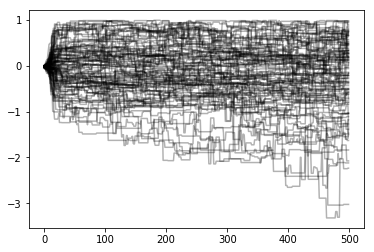

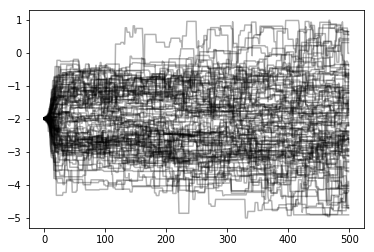

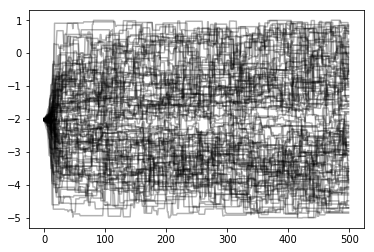

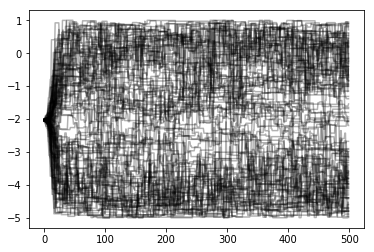

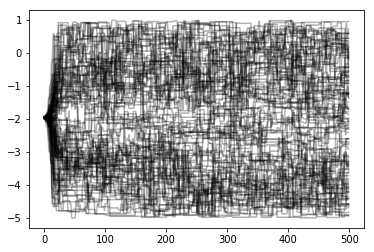

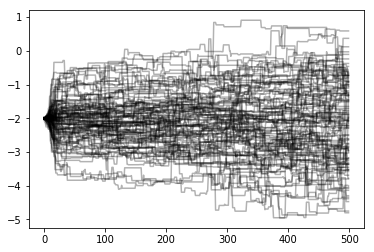

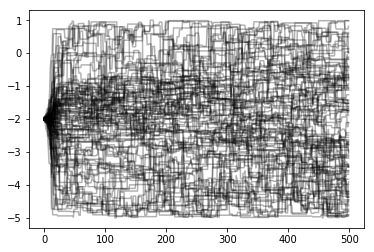

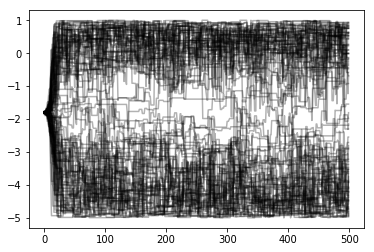

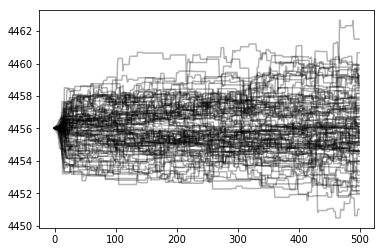

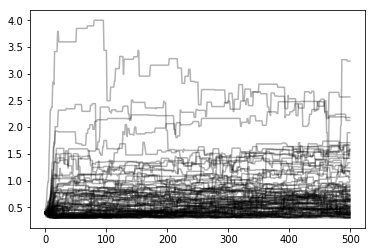

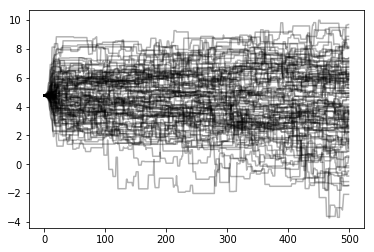

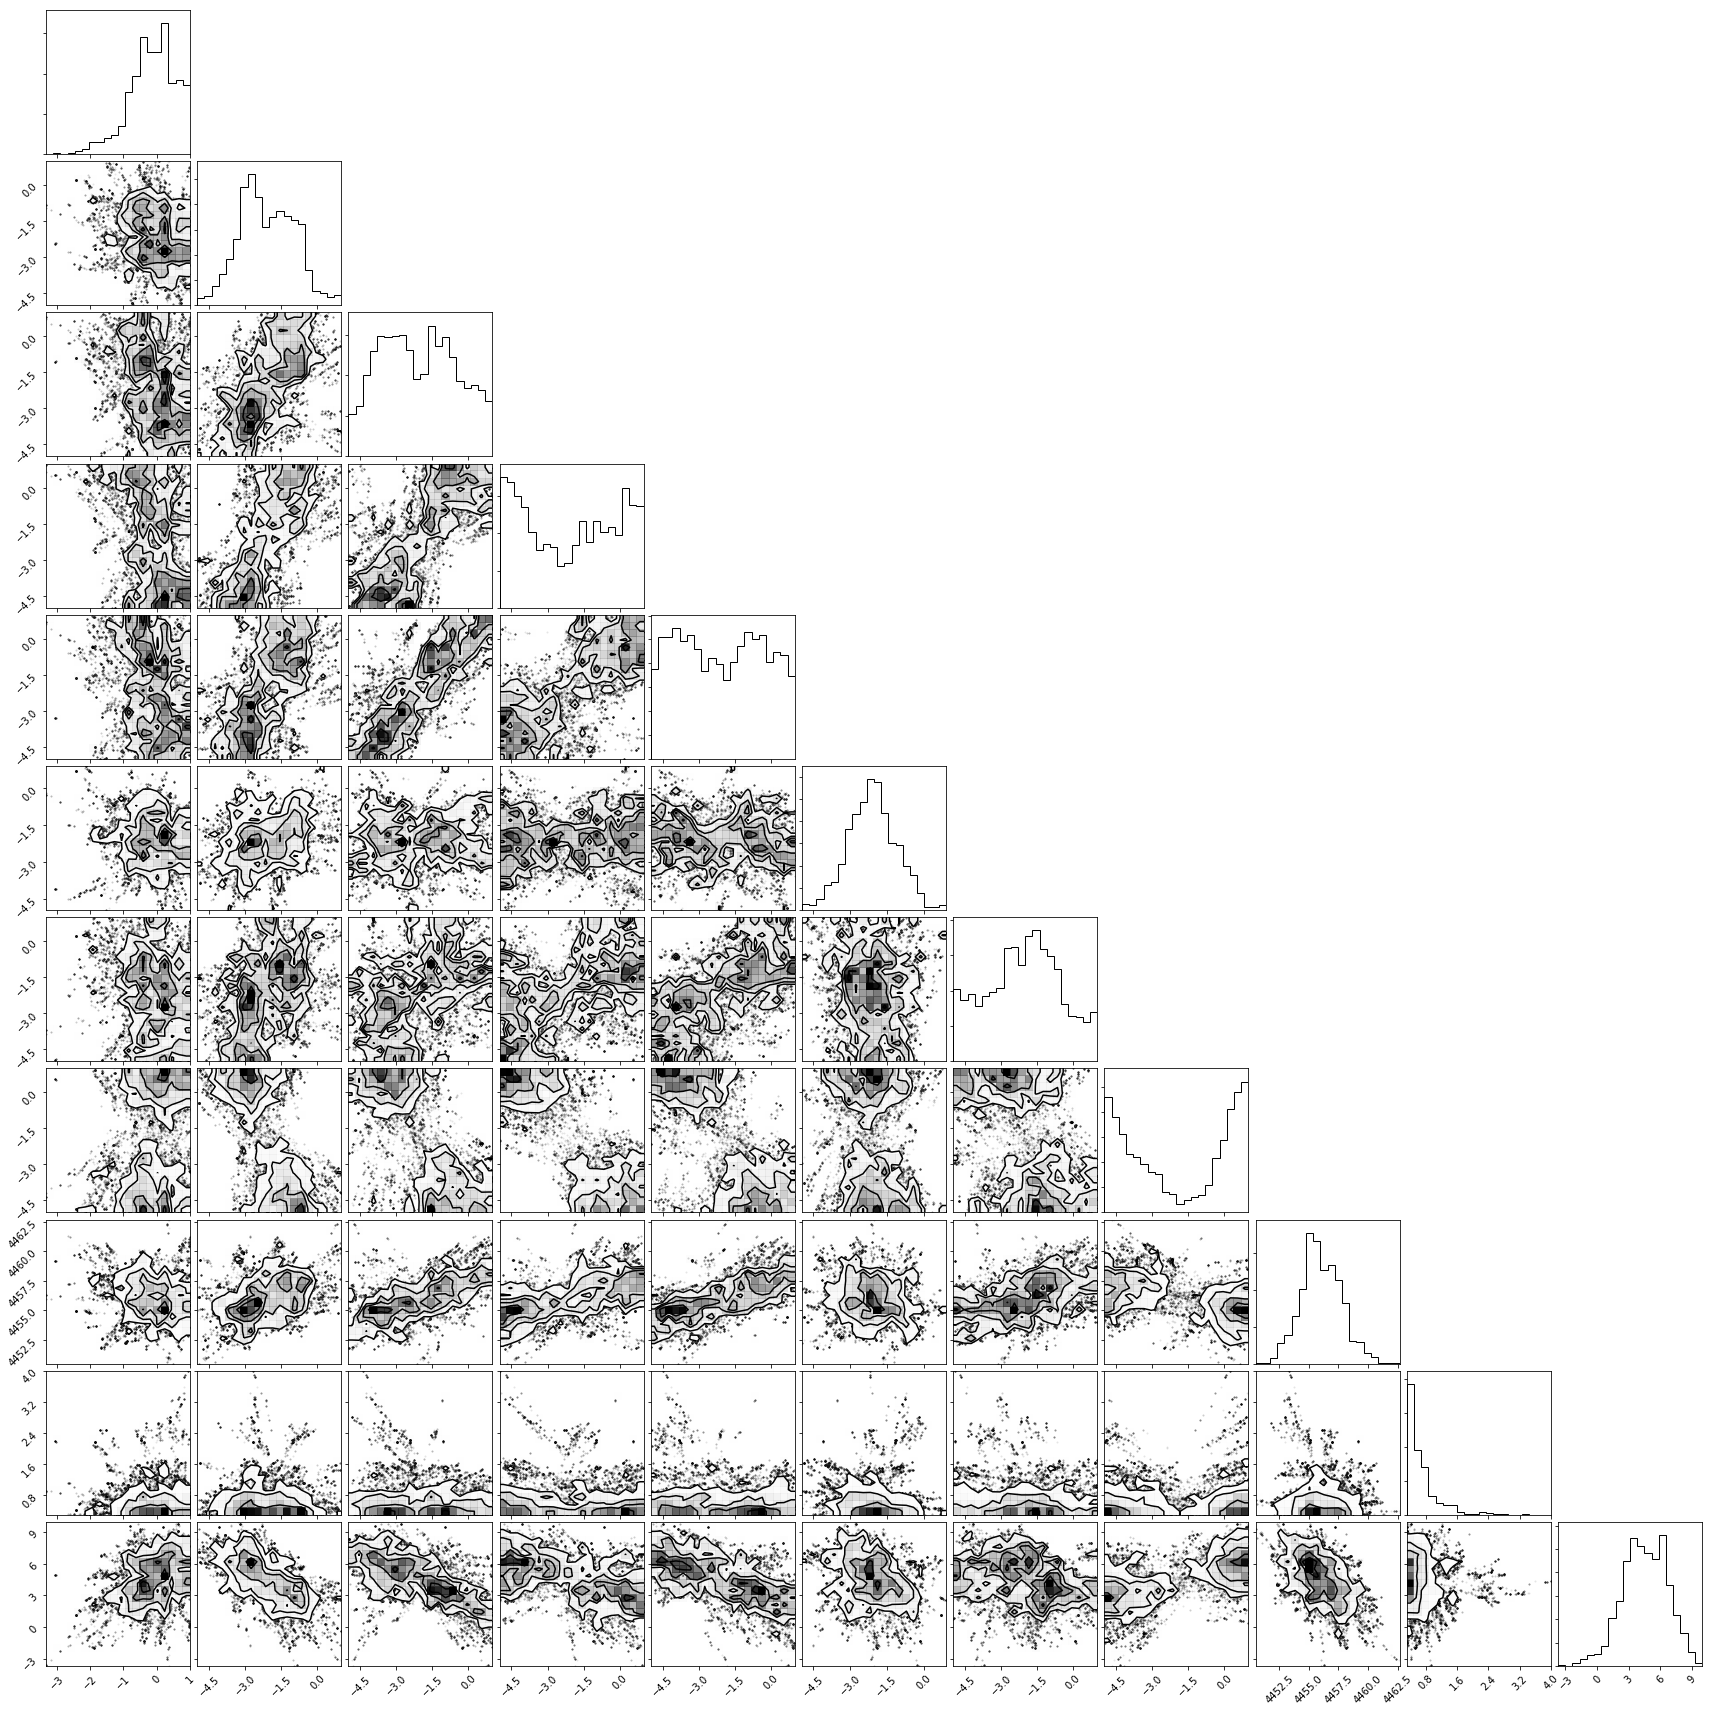

In [57]:
for i in range(ndim):
    plt.plot(sampler.chain[:,:,i].T, '-', color='k', alpha=0.3)
    plt.show()
    
samples = sampler.chain[:,50:,:].reshape((-1,ndim))
fig = corner.corner(samples)

In [59]:
ndim, nwalkers = len(popt), 100
p0 = [popt + 1e-2*np.random.randn(ndim) for i in range(nwalkers)]

sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, args=(data_spec, spec_err))
pos, prob, state = sampler.run_mcmc(p0,500)

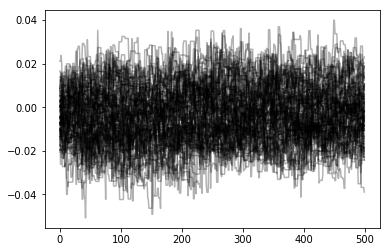

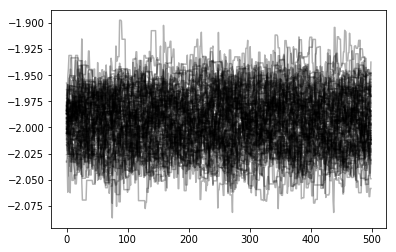

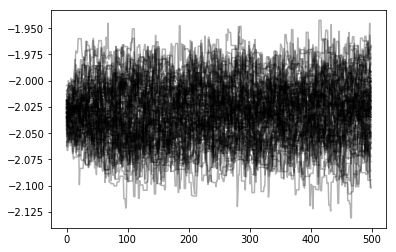

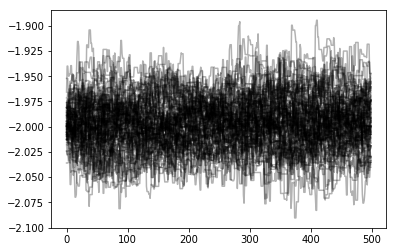

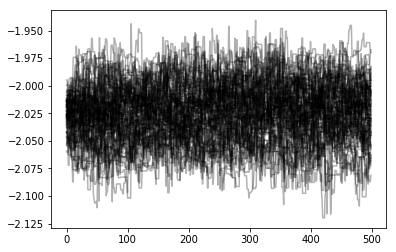

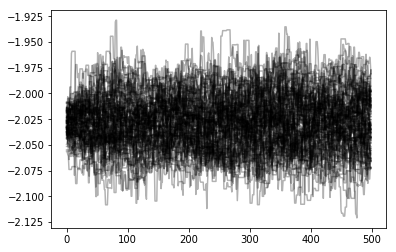

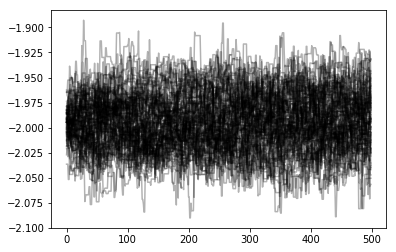

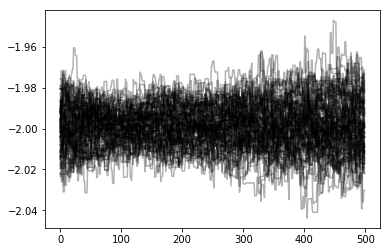

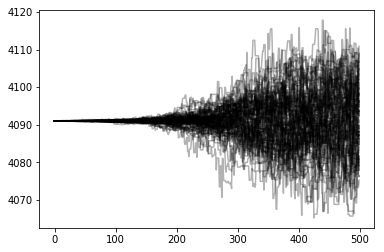

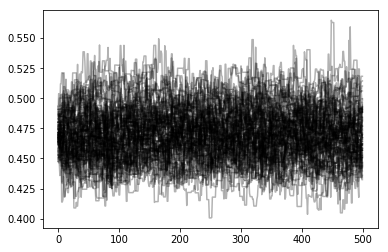

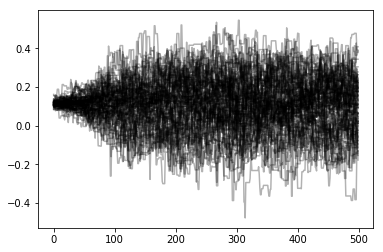

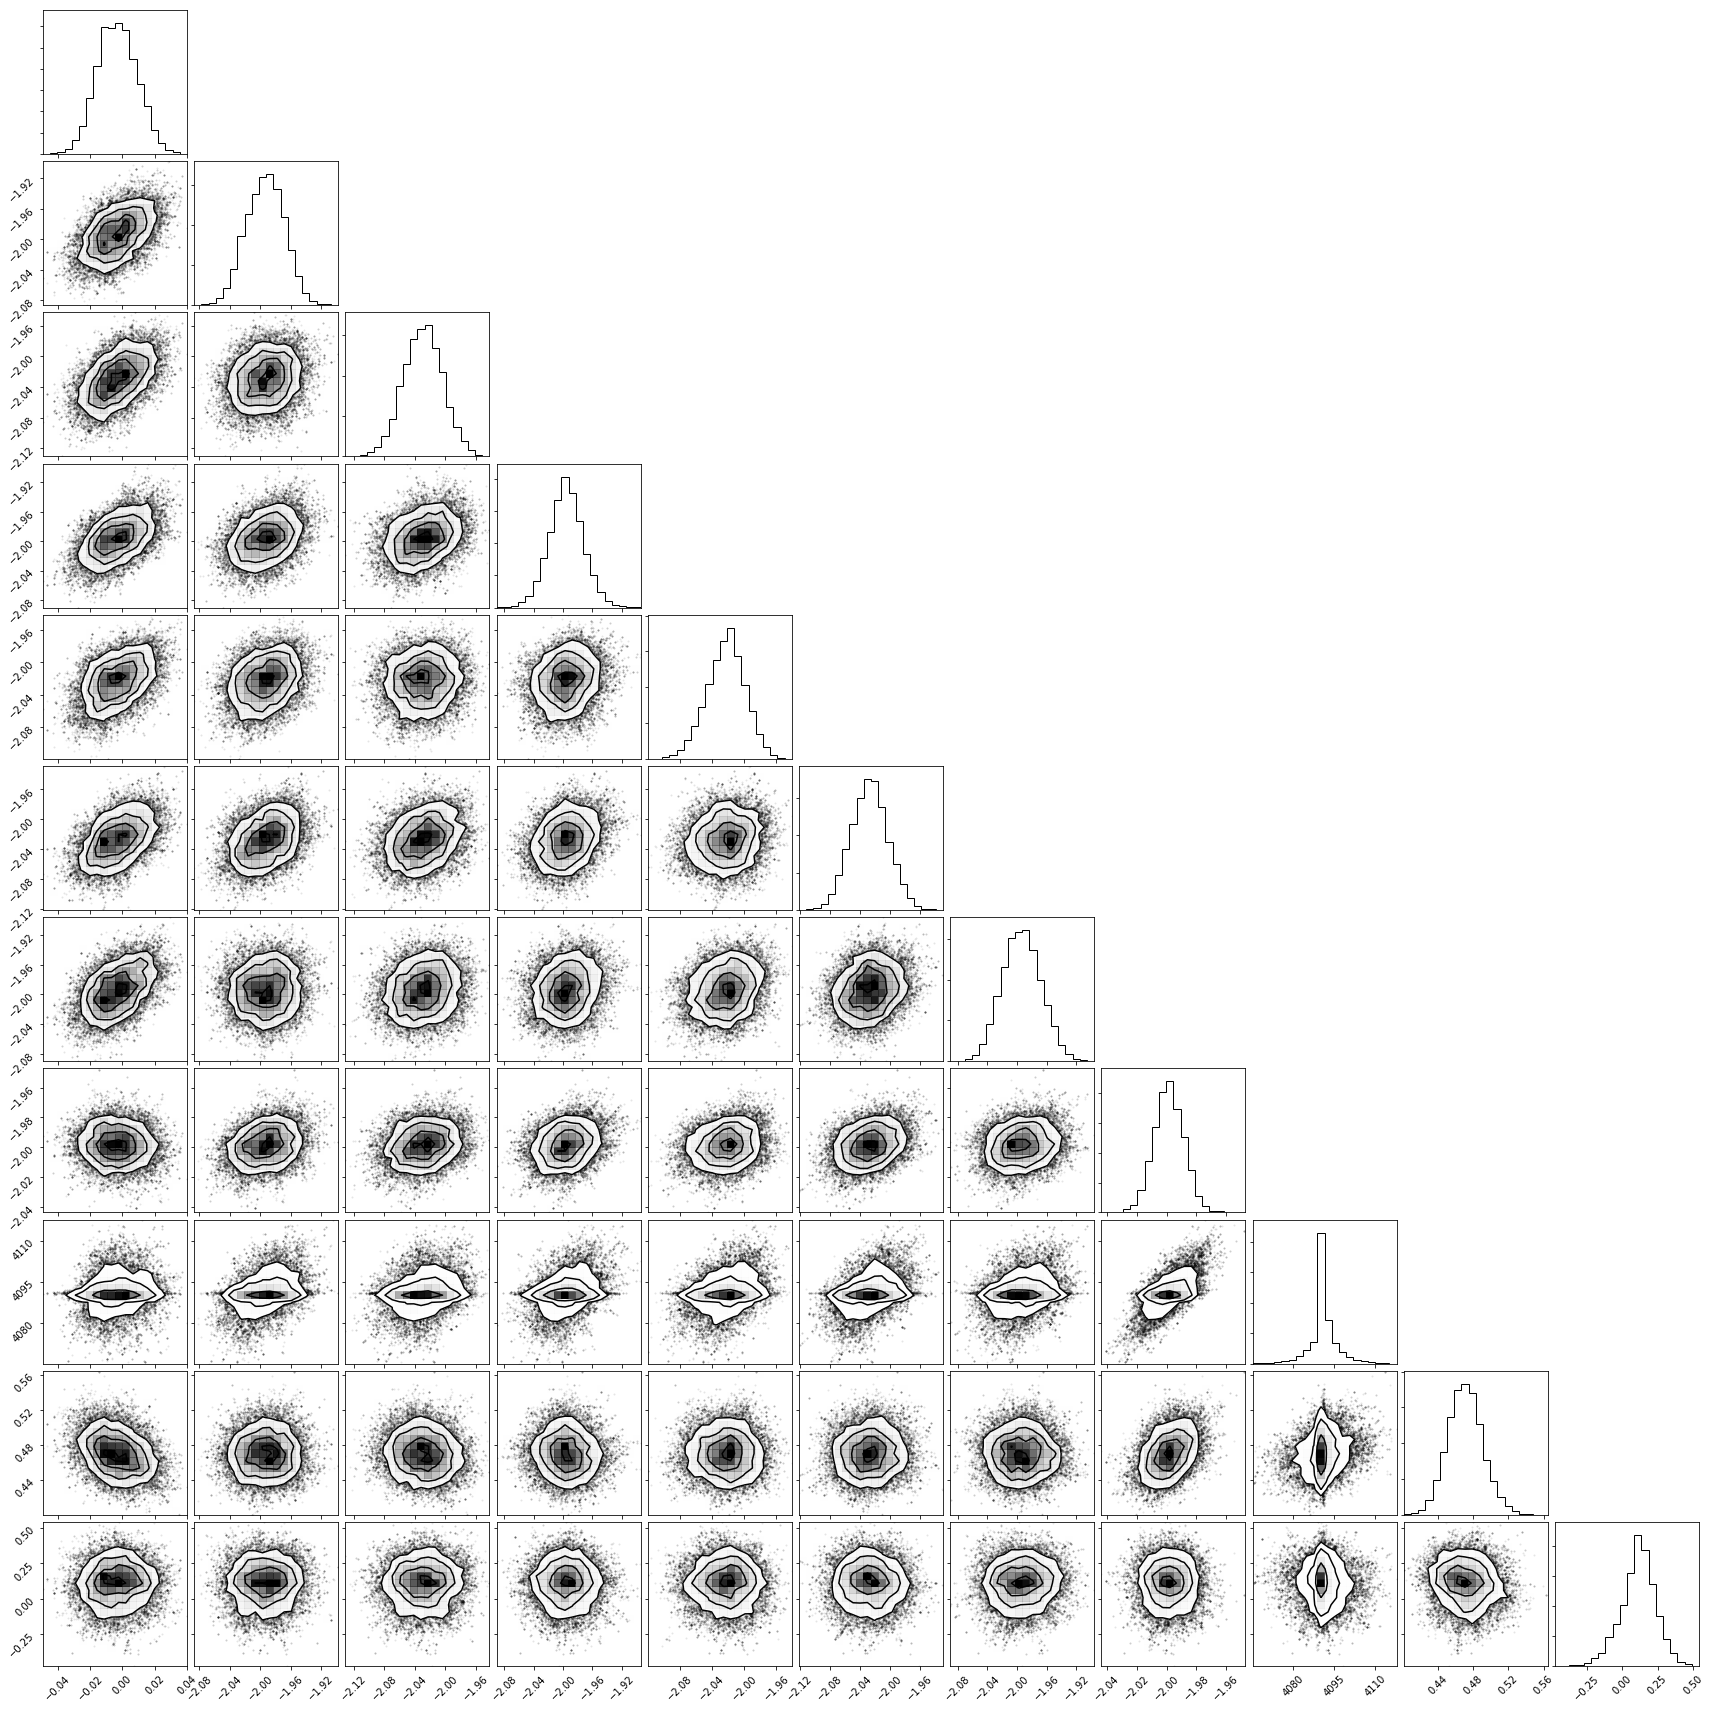

In [60]:
for i in range(ndim):
    plt.plot(sampler.chain[:,:,i].T, '-', color='k', alpha=0.3)
    plt.show()
    
samples = sampler.chain[:,50:,:].reshape((-1,ndim))
fig = corner.corner(samples)